# Heart Disease Detection

## Data Preprocessing

#### Importing data

In [107]:
import pandas as pd
student_data = pd.read_csv('student_version.csv')
features = student_data.drop('HeartDisease',axis=1)
target = student_data['HeartDisease']

In [108]:
categorical = features.select_dtypes(include=['object']).columns
numerical = features.select_dtypes(exclude=['object']).columns

#### Encode the categorical features

In [109]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first',sparse_output=False)
encoded_cols = ohe.fit_transform(features[categorical])

encoded_cols_df = pd.DataFrame(encoded_cols,columns=ohe.get_feature_names_out())
features = pd.concat([features.drop(categorical,axis=1),encoded_cols_df],axis=1)

#### Splitting the data into training and testing sets

In [110]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.25)

#### Standardize the numerical features

In [111]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
x_train_transformed = np.concatenate(
    [scaler.fit_transform(x_train[numerical]),
     x_train[ohe.get_feature_names_out()].values
     ], axis=1)


x_test_transformed = np.concatenate(
    [scaler.transform(x_test[numerical]),
     x_test[ohe.get_feature_names_out()].values
     ], axis=1)

### KNN Model
#### Define the optimization fuction for hyperparameters

In [112]:
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


def objective(trial):
    k = trial.suggest_int('k', 1, 13)
    metric = trial.suggest_categorical(
        'metric', ['euclidean', 'manhattan', 'minkowski'])
    model = KNeighborsClassifier(n_neighbors=k, metric=metric)
    score = cross_val_score(model, x_train_transformed, y_train, cv=5)
    accuracy = score.mean()
    return accuracy

In [113]:
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

sampler_grid = TPESampler()
pruner_grid = MedianPruner()
direction_grid = 'maximize'

study = optuna.create_study(
    sampler=sampler_grid, pruner=pruner_grid, direction=direction_grid)
study.optimize(objective, n_trials=18)
print("Best Trial")
print(" Best Parameters:  ", study.best_params)
print(" Best Score:  ", study.best_value)

[I 2024-09-12 18:41:30,657] A new study created in memory with name: no-name-2cf15632-c54b-478c-a02b-9f0d3d01f9b0
[I 2024-09-12 18:41:30,752] Trial 0 finished with value: 0.8581818181818182 and parameters: {'k': 9, 'metric': 'manhattan'}. Best is trial 0 with value: 0.8581818181818182.
[I 2024-09-12 18:41:30,837] Trial 1 finished with value: 0.8618181818181819 and parameters: {'k': 8, 'metric': 'minkowski'}. Best is trial 1 with value: 0.8618181818181819.
[I 2024-09-12 18:41:30,914] Trial 2 finished with value: 0.8163636363636364 and parameters: {'k': 1, 'metric': 'euclidean'}. Best is trial 1 with value: 0.8618181818181819.
[I 2024-09-12 18:41:31,000] Trial 3 finished with value: 0.8636363636363636 and parameters: {'k': 13, 'metric': 'euclidean'}. Best is trial 3 with value: 0.8636363636363636.
[I 2024-09-12 18:41:31,085] Trial 4 finished with value: 0.8636363636363636 and parameters: {'k': 12, 'metric': 'euclidean'}. Best is trial 3 with value: 0.8636363636363636.
[I 2024-09-12 18:41

Best Trial
 Best Parameters:   {'k': 13, 'metric': 'manhattan'}
 Best Score:   0.8709090909090909


#### build the model using the optimized hyperparameters

In [114]:
knn_model = KNeighborsClassifier(
    n_neighbors=study.best_params["k"], metric=study.best_params["metric"], p=2)

In [115]:
knn_model.fit(x_train_transformed, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=13)

In [116]:
y_predict_knn = knn_model.predict(x_test_transformed)

In [117]:
from sklearn.metrics import accuracy_score
knn_accuracy = accuracy_score(y_test, y_predict_knn)

print("Accuracy of the model is:", knn_accuracy)

Accuracy of the model is: 0.8804347826086957


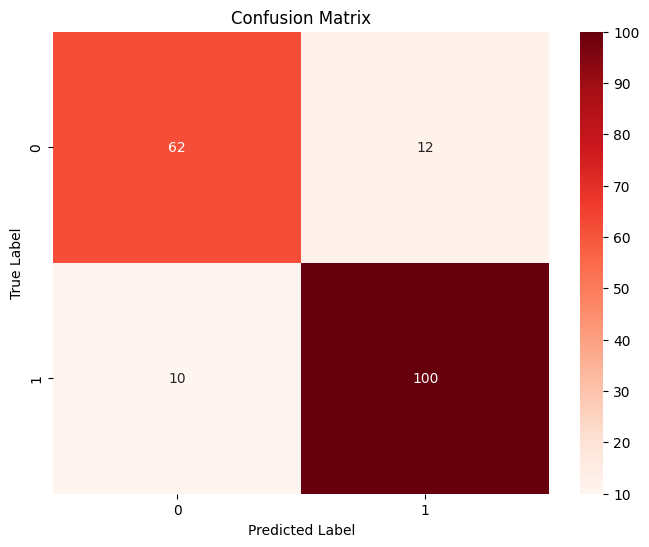

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_predict_knn)


# Plot the confusion matrix using Seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Logistic Regression Model


In [119]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=10000)

In [120]:
log_model.fit(x_train_transformed, y_train)

LogisticRegression(max_iter=10000)

In [121]:
y_predict_log = log_model.predict(x_test_transformed)

In [122]:
from sklearn.metrics import accuracy_score
log_accuracy = accuracy_score(y_test, y_predict_log)

print("Accuracy of the model is:", log_accuracy)

Accuracy of the model is: 0.8695652173913043


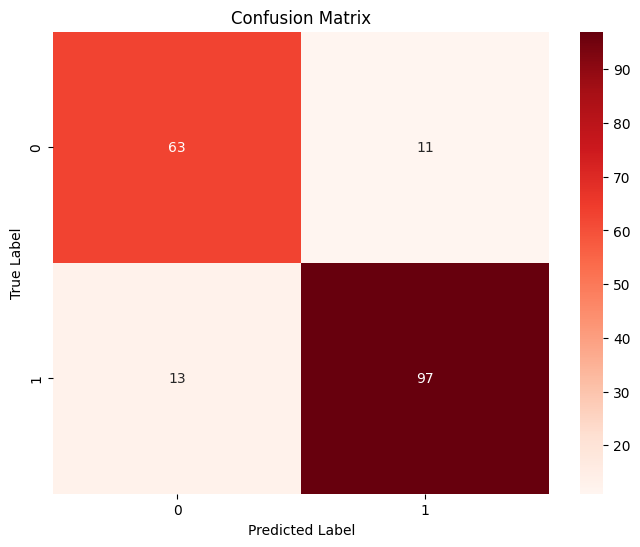

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_predict_log)


# Plot the confusion matrix using Seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### MLP Model
#### Calculate threshold value 

In [124]:
import numpy as np
threshold = np.sum(y_train)/y_train.shape[0]

#### Define the optimization fuction for hyperparameters

In [125]:
import os
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

X=x_train_transformed
y=y_train

def create_model(num_layers, units_per_layer, activation_per_layer, dropout_per_layer, learning_rate, optimizer_name):
    model = Sequential()
    model.add(Input(shape=(x_train_transformed.shape[1],)))

    for i in range(0, num_layers-1):
        model.add(Dense(units_per_layer[i],
                  activation=activation_per_layer[i]))
        model.add(Dropout(dropout_per_layer[i]))

    model.add(Dense(1, activation=activation_per_layer[num_layers-1]))

    optimizer = Adam(learning_rate=learning_rate) if optimizer_name == 'adam' else SGD(
        learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


def objective(trial):
    num_layers = trial.suggest_int('num_layers', 2, 5)
    units_per_layer = [trial.suggest_int(
        f'num_units_layer_{i}', 32, 128) for i in range(num_layers)]
    activation_per_layer = [trial.suggest_categorical(f'activation_{i}', [
                                                      'relu', 'tanh', 'sigmoid']) for i in range(num_layers)]
    dropout_per_layer = [trial.suggest_float(
        f'dropout_{i}', 0.2, 0.5) for i in range(num_layers-1)]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1,log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    model = KerasClassifier(model=create_model, num_layers=num_layers, units_per_layer=units_per_layer,
                            activation_per_layer=activation_per_layer, dropout_per_layer=dropout_per_layer,
                            learning_rate=learning_rate, optimizer_name=optimizer_name, epochs=20, batch_size=32, verbose=0)

    scores = cross_val_score(model, x_train_transformed, y_train, cv=5, scoring='accuracy')
    return scores.mean()

In [126]:
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

sampler_grid = TPESampler()
pruner_grid = MedianPruner()
direction_grid = 'maximize'

study = optuna.create_study(
    sampler=sampler_grid, pruner=pruner_grid, direction=direction_grid)

study.optimize(objective, n_trials=30)

print(f"Best hyperparameters: {study.best_params}")
print(f"Best score: {study.best_value}")

[I 2024-09-12 18:41:33,049] A new study created in memory with name: no-name-dedae6dc-6201-45e8-a81c-2d16d007397d
[I 2024-09-12 18:41:54,326] Trial 0 finished with value: 0.8163636363636364 and parameters: {'num_layers': 5, 'num_units_layer_0': 112, 'num_units_layer_1': 38, 'num_units_layer_2': 108, 'num_units_layer_3': 96, 'num_units_layer_4': 40, 'activation_0': 'tanh', 'activation_1': 'tanh', 'activation_2': 'sigmoid', 'activation_3': 'sigmoid', 'activation_4': 'relu', 'dropout_0': 0.3224139046930222, 'dropout_1': 0.49866279282107917, 'dropout_2': 0.3716441412536426, 'dropout_3': 0.32692668086133636, 'learning_rate': 0.005365204630171573, 'optimizer': 'adam'}. Best is trial 0 with value: 0.8163636363636364.
[I 2024-09-12 18:42:15,577] Trial 1 finished with value: 0.5145454545454545 and parameters: {'num_layers': 5, 'num_units_layer_0': 103, 'num_units_layer_1': 38, 'num_units_layer_2': 58, 'num_units_layer_3': 113, 'num_units_layer_4': 97, 'activation_0': 'sigmoid', 'activation_1': 

Best hyperparameters: {'num_layers': 2, 'num_units_layer_0': 78, 'num_units_layer_1': 98, 'activation_0': 'sigmoid', 'activation_1': 'sigmoid', 'dropout_0': 0.39743003511958425, 'learning_rate': 0.013421790527907615, 'optimizer': 'adam'}
Best score: 0.86


#### build the model using the optimized hyperparameters

In [127]:
def create_model(**kwargs):
    num_layers = kwargs['num_layers']
    units_per_layer = kwargs['units_per_layer']
    activation_per_layer = kwargs['activation_per_layer']
    dropout_per_layer = kwargs['dropout_per_layer']
    learning_rate = kwargs['learning_rate']
    optimizer_name = kwargs['optimizer_name']
    input_shape = kwargs['input_shape']

    model = Sequential()
    model.add(Input(shape=input_shape))

    for i in range(num_layers - 1):
        model.add(Dense(units_per_layer[i],
                  activation=activation_per_layer[i]))
        model.add(Dropout(dropout_per_layer[i]))

    model.add(Dense(1, activation=activation_per_layer[num_layers - 1]))

    optimizer = Adam(learning_rate=learning_rate) if optimizer_name == 'adam' else SGD(
        learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [128]:
num_layers = study.best_params["num_layers"]
units_per_layer = [
    study.best_params[f"num_units_layer_{i}"] for i in range(num_layers)]
activation_per_layer = [
    study.best_params[f"activation_{i}"] for i in range(num_layers)]
dropout_per_layer = [
    study.best_params[f"dropout_{i}"] for i in range(num_layers - 1)]
learning_rate = study.best_params["learning_rate"]
optimizer_name = study.best_params["optimizer"]
input_shape = (x_train_transformed.shape[1],)

In [140]:
mlp_model = KerasClassifier(model=create_model, num_layers=num_layers,
                            units_per_layer=units_per_layer,
                            activation_per_layer=activation_per_layer,
                            dropout_per_layer=dropout_per_layer,
                            learning_rate=learning_rate,
                            optimizer_name=optimizer_name,
                            input_shape=input_shape,
                            epochs=10,
                            batch_size=64,
                            verbose=0)
mlp_model.fit(x_train_transformed, y_train)

KerasClassifier(
	model=<function create_model at 0x000002134A8A0E00>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	num_layers=2
	units_per_layer=[78, 98]
	activation_per_layer=['sigmoid', 'sigmoid']
	dropout_per_layer=[0.39743003511958425]
	learning_rate=0.013421790527907615
	optimizer_name=adam
	input_shape=(15,)
	class_weight=None
)

In [141]:
y_pred_probs = mlp_model.predict(x_test_transformed)

y_predict_mlp = (y_pred_probs >= threshold).astype(int)

mlp_accuracy = accuracy_score(y_test, y_predict_mlp)

print(f'Accuracy: {mlp_accuracy}')

Accuracy: 0.875


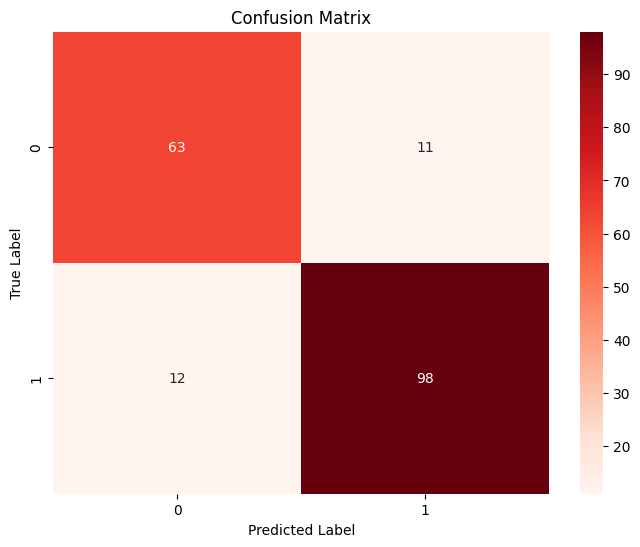

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_predict_mlp)


# Plot the confusion matrix using Seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Accuracy based on training and testing sets

In [143]:
print("KNN Accuracy = ", knn_accuracy)
print("Logistic Regression Accuracy = ", log_accuracy)
print("MLP Accuracy = ", mlp_accuracy)

KNN Accuracy =  0.8804347826086957
Logistic Regression Accuracy =  0.8695652173913043
MLP Accuracy =  0.875


In [144]:
import numpy as np
features = np.concatenate((x_train_transformed, x_test_transformed), axis=0)
target = np.concatenate((y_train, y_test), axis=0)
threshold = np.sum(target)/target.shape[0]

#### Train models on the whole data set

In [145]:
knn_model.fit(features,target)
log_model.fit(features,target)
mlp_model.fit(features,target)

KerasClassifier(
	model=<function create_model at 0x000002134A8A0E00>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	num_layers=2
	units_per_layer=[78, 98]
	activation_per_layer=['sigmoid', 'sigmoid']
	dropout_per_layer=[0.39743003511958425]
	learning_rate=0.013421790527907615
	optimizer_name=adam
	input_shape=(15,)
	class_weight=None
)

In [146]:
import joblib

mlp_model.model_.save('./Flask_App/app_ml/models/mlp_model.h5')

joblib.dump(knn_model, './Flask_App/app_ml/models/knn_model.pkl')
joblib.dump(log_model, './Flask_App/app_ml/models/log_model.pkl')
joblib.dump(scaler,'./Flask_App/app_ml/models/scaler.pkl')
joblib.dump(ohe, './Flask_App/app_ml/models/ohe.pkl')
joblib.dump(threshold, './Flask_App/app_ml/models/threshold.pkl')

['./app_ml/models/threshold.pkl']